In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import netCDF4
from mhm_dataprocessing import *

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.integrate import cumulative_trapezoid


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

### Read data

In [3]:
cdf_da = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\drought_analysis\soil_moisture_cdf.nc", engine='netcdf4')
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\mhm_mon_fluxes.nc")

#shapefile mask
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")

#soil hydraulic properties
soil_hydr_grid = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\mHM_restart_001.nc")

#### Soil hydraulic properties

Wilting Point and Field Capacity

#### Mask data outside study domain

In [5]:
#be_data = clip_to_region(be_shp, mhm_fluxes)
#use mhm fluxes greater than 0.3 at the first timestep as mask
mask = mhm_fluxes['SM_L02'].isel(time=0)
#mask the data
mhm_mask = mask.where(mask > 0.7)*0 + 1
#Apply mask to mhm fluxes
be_data = mhm_fluxes.where(mhm_mask == 1)

#resample to month ends
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SM_Lall','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= be_data[variables].resample(time='ME').mean()
mhm_fluxes_year = be_data[variables].resample(time='YE').sum()

#### Select Data for vegetation active season

In [6]:
#select the variable of interest
variable = 'SM_Lall'

#select the data for the variable of interest
data_mon = mhm_fluxes_mon[[variable]]

#Period of interest. In this case, the vegetation active season
active_season = [4,5,6,7,8,9,10]

#extract values for summer months
data_vas_mons = data_mon.sel(time=data_mon.time.dt.month.isin(active_season))

#average soil moisture for active vegetation months for each year
data_vas_avg = data_vas_mons.groupby('time.year').mean()

In [7]:
month = 7
cdf_x = cdf_da['CDF'].sel(month=month).sel(lat=50.2, lon = 5.5, method = 'nearest')
sm_bins = cdf_da['sm_bins'].sel(month=month).sel(lat=50.2, lon = 5.5, method = 'nearest')
#soil_moisture = data_vas_mons['SM_Lall'].sel(time=data_vas_mons.time.dt.month == month).sel(lat=50.2, lon = 5.5, method = 'nearest')

In [8]:
#subset the data to debug
subset_sm = data_vas_mons.sel(lat = slice(50.55, 50.5), lon = slice(4.5, 4.55))

In [ ]:
cdf_length = 50  # Number of points for the CDF, should be greater than the length of data

# Preallocate lists for storing DataArrays
cdf_data_list = []
bin_data_list = []
optimal_bands = []

for month in active_season:
    # Subset for the current month
    data_mon = subset_sm.sel(time=subset_sm.time.dt.month == month)
    
    # Preallocate arrays for storing the CDF and bins
    nlat, nlon = len(data_mon.lat), len(data_mon.lon)
    cdf_array = np.full((nlat, nlon, cdf_length), np.nan)
    sm_bins_map = np.full((nlat, nlon, cdf_length), np.nan)
    
    for j in range(nlat):
        for i in range(nlon):
            # Extract soil moisture time series for the current grid cell
            soil_moisture = data_mon[variable].isel(lat=j, lon=i).values
            
            # Skip if all NaN
            if np.isnan(soil_moisture).all():
                continue
            
            # Remove remaining NaNs
            soil_moisture = soil_moisture[~np.isnan(soil_moisture)]
            if len(soil_moisture) == 0:
                continue  # all were NaN
            
            # Check variance
            if np.std(soil_moisture) < 1e-6:
                # Skip if there's essentially no variation
                continue
            
            # Compute optimal bandwidth from your custom function
            bandwidths = np.linspace(0.001, 0.1, 50)
            optimal_h = compute_optimal_h(soil_moisture, bandwidths)
            optimal_bands.append(optimal_h)
            
            # Fit KDE
            kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
            kde.fit(soil_moisture[:, None])
            
            # Define bins for the CDF
            sm_bins = np.linspace(
                soil_moisture.min() * 0.8,
                soil_moisture.max() * 1.1,
                cdf_length
            )
            
            # Evaluate PDF
            logprob = kde.score_samples(sm_bins[:, None])
            prob_density = np.exp(logprob)
            
            # CDF via cumulative sum (rectangle rule)
            dx = sm_bins[1] - sm_bins[0]
            cdf = np.cumsum(prob_density) * dx
            
            # Normalize so the final CDF == 1
            if cdf[-1] > 0:
                cdf /= cdf[-1]
            else:
                cdf[:] = np.nan
            
            # Store in the preallocated arrays
            cdf_array[j, i, :] = cdf
            sm_bins_map[j, i, :] = sm_bins
    
    # Convert results to DataArrays
    cdf_da = xr.DataArray(
        cdf_array,
        coords=[data_mon.lat, data_mon.lon, np.arange(cdf_length)],
        dims=['lat', 'lon', 'cdf_index'],
        name='CDF'
    )
    sm_bins_da = xr.DataArray(
        sm_bins_map,
        coords=[data_mon.lat, data_mon.lon, np.arange(cdf_length)],
        dims=['lat', 'lon', 'cdf_index'],
        name='sm_bins'
    )
    
    # Aadd the 'month' dimension to each DataArray.
    # Expand dims to have a size-1 dimension for month, then assign month as coordinate.
    cdf_da = cdf_da.expand_dims(dim={'month': [month]})
    sm_bins_da = sm_bins_da.expand_dims(dim={'month': [month]})
    
    # Append to lists for later concatenation
    cdf_data_list.append(cdf_da)
    bin_data_list.append(sm_bins_da)

# Concatenate all months along the new 'month' dimension
cdf_merged = xr.concat(cdf_data_list, dim='month')
bins_merged = xr.concat(bin_data_list, dim='month')

# cdf_merged and bins_merged have dims: (month, lat, lon, cdf_index)
# 'month' has the active season values, and 'cdf_index' indexes the cdf_length points along the PDF/CDF curves.

# combine into a single Dataset
results_ds = xr.Dataset({'CDF': cdf_merged, 'sm_bins': bins_merged})

In [ ]:
subset_cdf = cdf_da.sel(lat=slice(50.5, 50.1), lon=slice(4.1, 4.5))
subset_sm = data_vas_mons.sel(lat=slice(50.5, 50.1), lon=slice(4.1, 4.5))

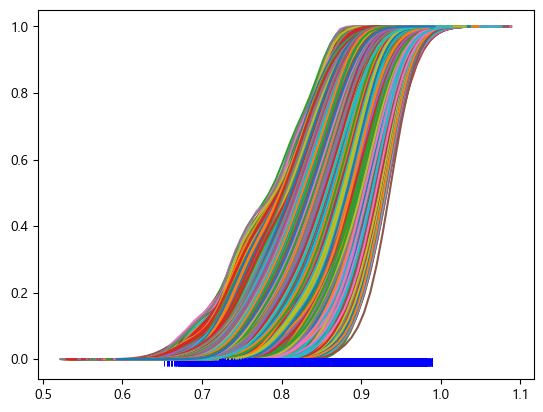

In [ ]:
month = 6
ds = subset_cdf
for lat in range(len(ds.lat)):
    for lon in range(len(ds.lon)):
        
        plt.plot(ds['sm_bins'].sel(month=month).isel(lat=lat, lon=lon).values, ds['CDF'].sel(month=month).isel(lat=lat, lon=lon).values)
        #plt.plot(ds1['sm_bins'].sel(month=month).isel(lat=lat, lon=lon).values, ds1['CDF'].sel(month=month).isel(lat=lat, lon=lon).values, 'b', alpha=0.5)

        #soil moisture
        plt.plot(subset_sm['SM_Lall'].sel(time=subset_sm.time.dt.month == month).isel(lat=lat, lon=lon).values, np.full_like(subset_sm['SM_Lall'].sel(time=subset_sm.time.dt.month == month).isel(lat=lat, lon=lon), -0.01), '|b', markeredgewidth=0.7)
#plt.axhline(0, color='black', linestyle='--')

In [ ]:

drought_threshold = 0.2  # Percentile threshold for drought classification

# Initialize lists to store per-month results
percentile_data = []
drought_data = []
month_list = []

# Loop through summer months (same as CDF computation)
for month in active_season:
    print(f'Processing month: {month}', end='\r')

    # Ensure the month exists in CDF dataset
    if month not in cdf_da['month'].values:
        print(f"Skipping month {month} as it's not in the CDF dataset.")
        continue  # Skip if month not found

    # Extract soil moisture data for the current month only
    data_mon = data_vas_mons.sel(time=data_vas_mons.time.dt.month == month)

    # Initialize arrays for storing percentiles and drought classification
    percentile_map = np.full((len(data_mon.lat), len(data_mon.lon), len(data_mon.time)), np.nan)
    drought_map = np.full((len(data_mon.lat), len(data_mon.lon), len(data_mon.time)), np.nan)

    # Loop through grid cells
    for j in range(len(data_mon.lat)):  # Latitude
        for i in range(len(data_mon.lon)):  # Longitude
            try:
                # Extract CDF and bins for exact grid cell and month
                cdf = cdf_da['CDF'].sel(month=month).isel(lat=j, lon=i).values
                cdf_x = cdf_da['sm_bins'].sel(month=month).isel(lat=j, lon=i).values
            except IndexError:
                print(f"Skipping missing grid cell (lat={j}, lon={i}) in month {month}.", end = '\r')
                continue

            # Skip cells with no valid CDF data
            if np.isnan(cdf).all():
                continue
            
            # Process each time step in this month
            for t in range(len(data_mon.time)):
                current_sm = data_mon[variable].isel(lon=i, lat=j, time=t).values
                if np.isnan(current_sm):
                    continue
            
                # Compute percentile rank with boundary handling
                if current_sm < cdf_x.min():
                    percentile_rank = 0  # Below historical range
                elif current_sm > cdf_x.max():
                    percentile_rank = 1  # Above historical range
                else:
                    percentile_rank = np.interp(current_sm, cdf_x, cdf)

                percentile_map[j, i, t] = percentile_rank  # Store percentile
                
                # Classify drought (1 for drought, 0 for no drought)
                drought_map[j, i, t] = 1 if percentile_rank <= drought_threshold else 0

    # Append monthly results to lists
    percentile_data.append(percentile_map)
    drought_data.append(drought_map)
    month_list.append(month)

# Convert to xarray.DataArray
percentile_da = xr.DataArray(
    np.stack(percentile_data, axis=0),  # Stack along the time axis
    dims=['time', 'lat', 'lon'],
    coords={'time': data_vas_mons.time, 'lat': data_vas_mons.lat, 'lon': data_vas_mons.lon},
    name='Percentile'
)

drought_da = xr.DataArray(
    np.stack(drought_data, axis=0),
    dims=['time', 'lat', 'lon'],
    coords={'time': data_vas_mons.time, 'lat': data_vas_mons.lat, 'lon': data_vas_mons.lon},
    name='Drought'
)

# Combine into an xarray Dataset
drought_dataset = xr.Dataset({'Percentile': percentile_da, 'Drought': drought_da})


In [ ]:
mhm_fluxes_ann = mhm_fluxes_year['recharge'].where(mhm_fluxes_year['recharge']>0)
mhm_fluxes_mon['SM_L01'][31].plot(cmap = 'RdBu', robust = True)

#### Select a month to analyze SMI

In [10]:
#select values for June
data=mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month==6)

#select a time series from a specific location
sample_ts = mhm_fluxes_mon['SM_Lall'].sel(lon=5.5, lat=50.75, method='nearest')

In [11]:
ts_df = sample_ts.to_dataframe().drop(columns=['lat', 'lon'])

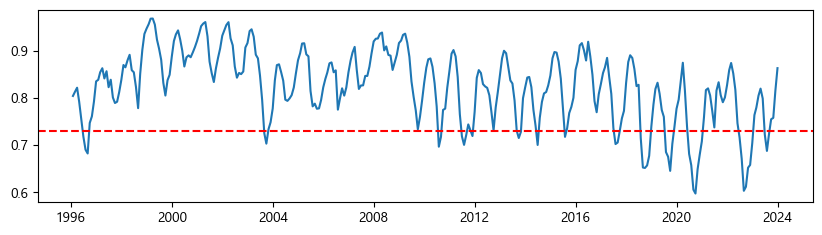

In [12]:
fig,ax=plt.subplots(figsize=(10,2.5))
plt.plot(ts_df.index, ts_df['SM_Lall'])
plt.axhline(y=0.73, color='r', linestyle='--')

#### SMI and drought characteristics

ref: https://www.nature.com/articles/s41558-018-0138-5

$SMI_{t} = F_{T}(x_{t})$


 Represents the quantile at the soil moisture fraction value x (normalized against the saturated soil water content). x t denotes the simulated monthly soil moisture fraction at a time t and is the empirical distribution function estimated using the kernel density estimator, $f_{t}(x)$

 $f_{t}(x) = \frac{1}{nh}\sum_{k=1}^{n}K(\frac{x-x_{k}}{h})$
  

 Here, $x_{1}$, …, $x_{n}$ n represents the simulated soil moisture fraction of a given calendar month during the reference period T; n denotes the number of calendar months within a given period (that is, 30 for a 30-year period); and $K$ represents a Gaussian kernel function with a bandwidth h. The bandwidth is estimated with GridSearch.
 
$K(x, x_{k}) = \frac{1}{\sqrt{2\pi h^{2}}}\exp(\frac{(x-x_{k})^{2}}{2h^{2}})$

A cell at time t is under drought when $SMI_{t}$  < $\tau$. Here, $\tau$ denotes that the soil water content in this cell is less than the values occurring $\tau$ × 100% of the time. In this study, $\tau$ is set to 0.2

  
### Bandwidth selection
Find the optimal bandwidth h for the distribution function.
GridsearchCV

-- --
Alternatively using Silverman's rule (has limitations)


https://towardsdatascience.com/bounded-kernel-density-estimation-2082dff3f47f

Silverman's rule of thumb, optimal when the underlying density being estimated is Gaussian

$h = \sigma * (\frac{4}{3n})^{-0.2}$

#### Kernel Density Estimation (Example)

Optimal bandwidth: 0.04268421052631579


Text(0, 0.5, 'Probability Density')

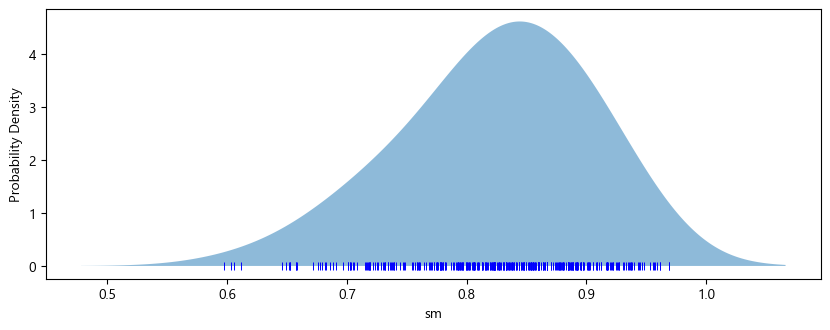

In [48]:
#GridSearchCV to find the optimal bandwidth
#extract values
soil_moisture = ts_df.values[:,0]
# Define a range of bandwidths to test
bandwidths =np.linspace(0.001, 0.1, 20)

# Perform cross-validated grid search for bandwidth h
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(soil_moisture[:, None])

# Optimal bandwidth
optimal_h = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {optimal_h}")

#///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# kernel density estimation
kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
kde.fit(soil_moisture[:, None]) #fit the KDE model to the data

#plot the kde
x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, 1000) 
#x used for evaluating the kernel density estimation (KDE) does not have to be the same as the original data points.
#  Instead, x is typically chosen as a smooth, evenly spaced range of values that covers the domain of the data.
#  This ensures that the KDE curve is displayed smoothly over the range of interest.
# x is for the visualization of the KDE, not for determining the underlying probabilities of your data

#evaluate the KDE at the x values
#range of soil moisture values
logprob = kde.score_samples(x[:, None]) #log of the probability density function

#probability density function
prob_density = np.exp(logprob)

#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

#plot the KDE
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.fill_between(x, prob_density, alpha=0.5)
#plot vertical lines (|) representing the soil moisture values, with height equal to -0.01
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)
plt.xlabel('sm')
plt.ylabel('Probability Density')

### Cumulative distribution function

Integrate the probability distribution function to obtain the CDF

In [49]:
# Compute the CDF by integrating the PDF
cdf = np.cumsum(prob_density) * (x[1] - x[0])

In [55]:
### calculare the probability of soil moisture being below 0.71
cdf_071 = np.interp(0.732, x, cdf)

#calculate the sm value corresponding to 0.2 cumulative probability
sm_02 = np.interp(0.2, cdf, x)
sm_02

0.7508994675034638

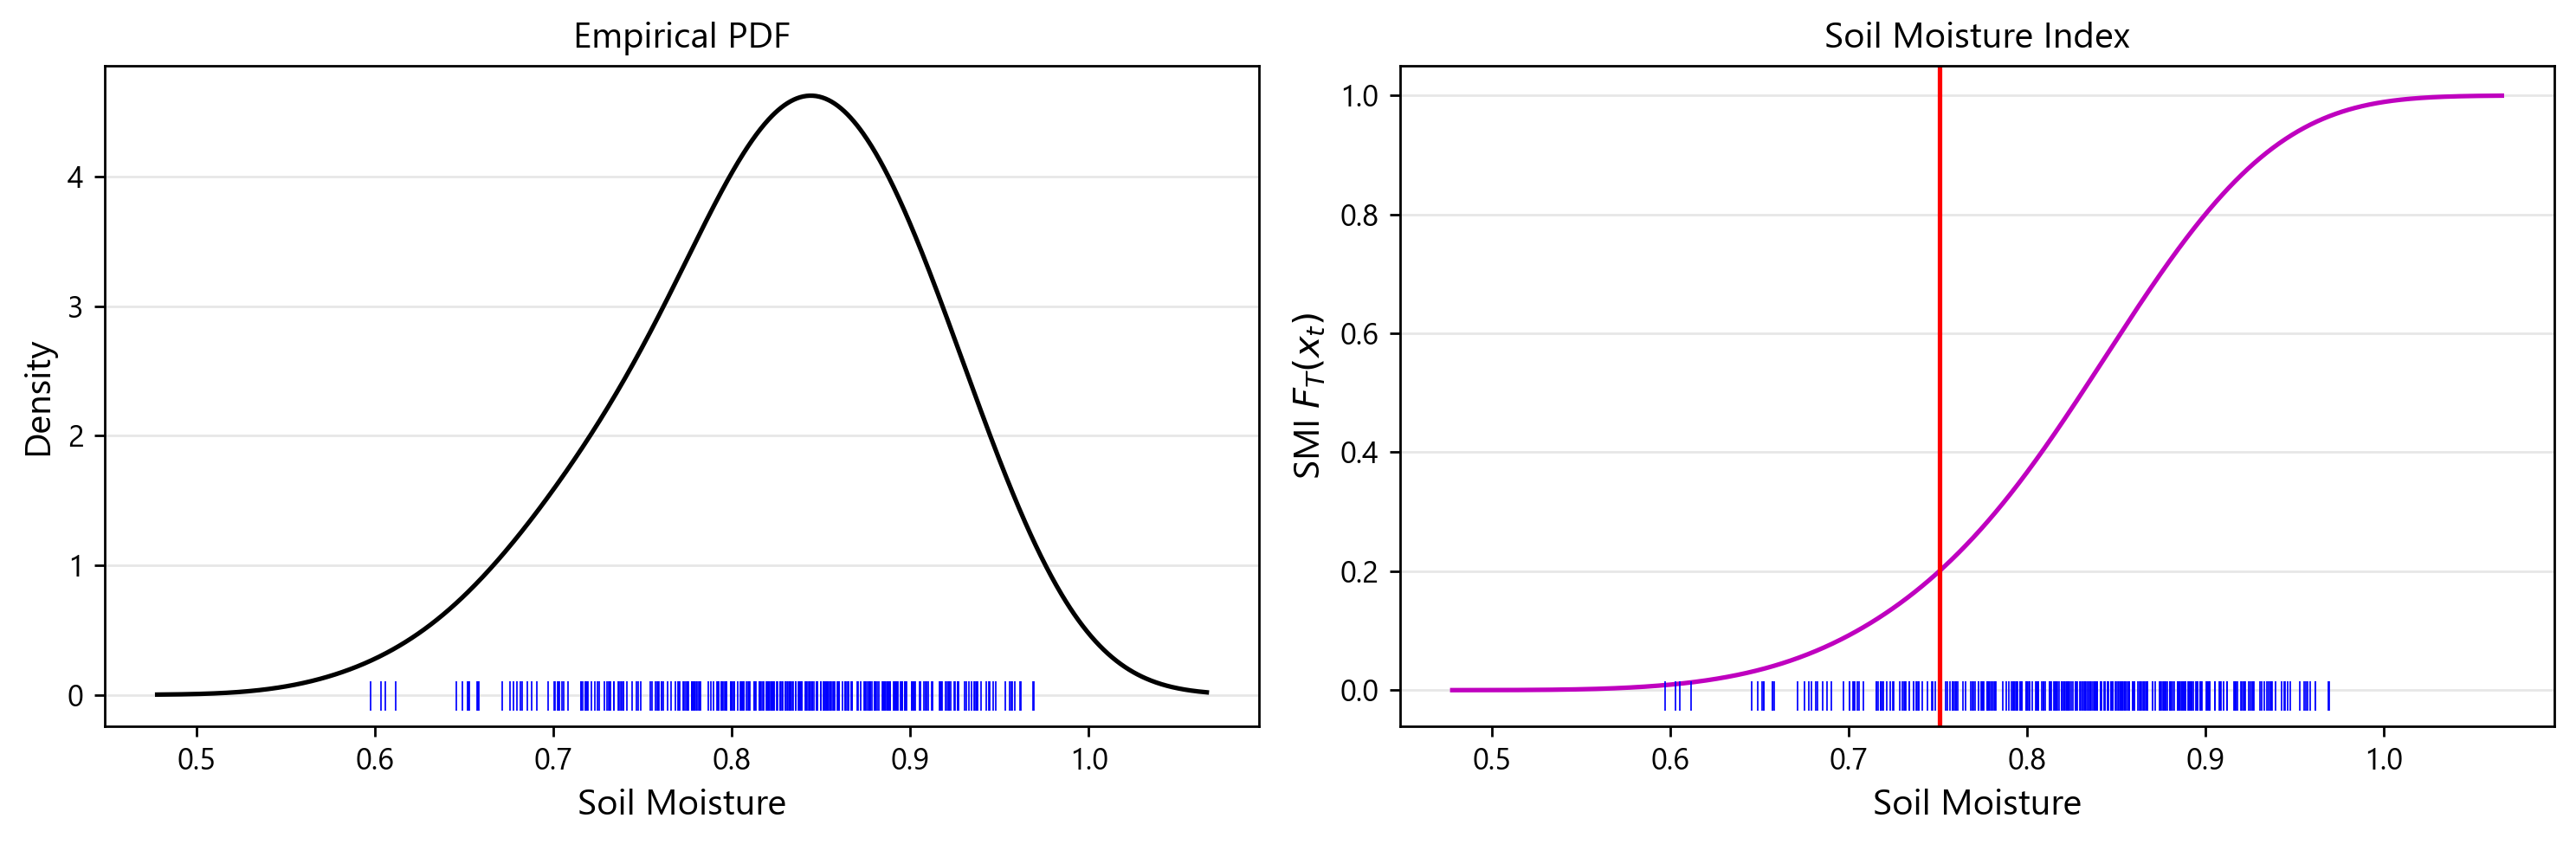

In [51]:
# Plot the PDF and CDF
plt.figure(figsize=(12, 4), dpi=250)
plt.subplot(1, 2, 1)
plt.plot(x, prob_density, c='k')
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.5,markersize=10)
#plt.axvline(sm_02, color='red', lw=0.5, label='20%')
plt.xlabel('Soil Moisture', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Empirical PDF', fontsize=12)
plt.grid(axis='y', alpha=0.3)
#plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='CDF', color='m', lw=1.5)
plt.axvline(sm_02, color='red', lw=1.5, label='20%')
#fill between the x values up to the threshold value
plt.fill_between(x, cdf, where=(x <= sm_02), color='red', alpha=0.)
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.5, markersize=10)
plt.grid(axis='y', alpha=0.3)
plt.xlabel('Soil Moisture', fontsize=12)
plt.ylabel('SMI $F_{T} (x_{t})$', fontsize=12)
plt.title('Soil Moisture Index', fontsize=12)
#plt.legend()
plt.tight_layout()
plt.show()

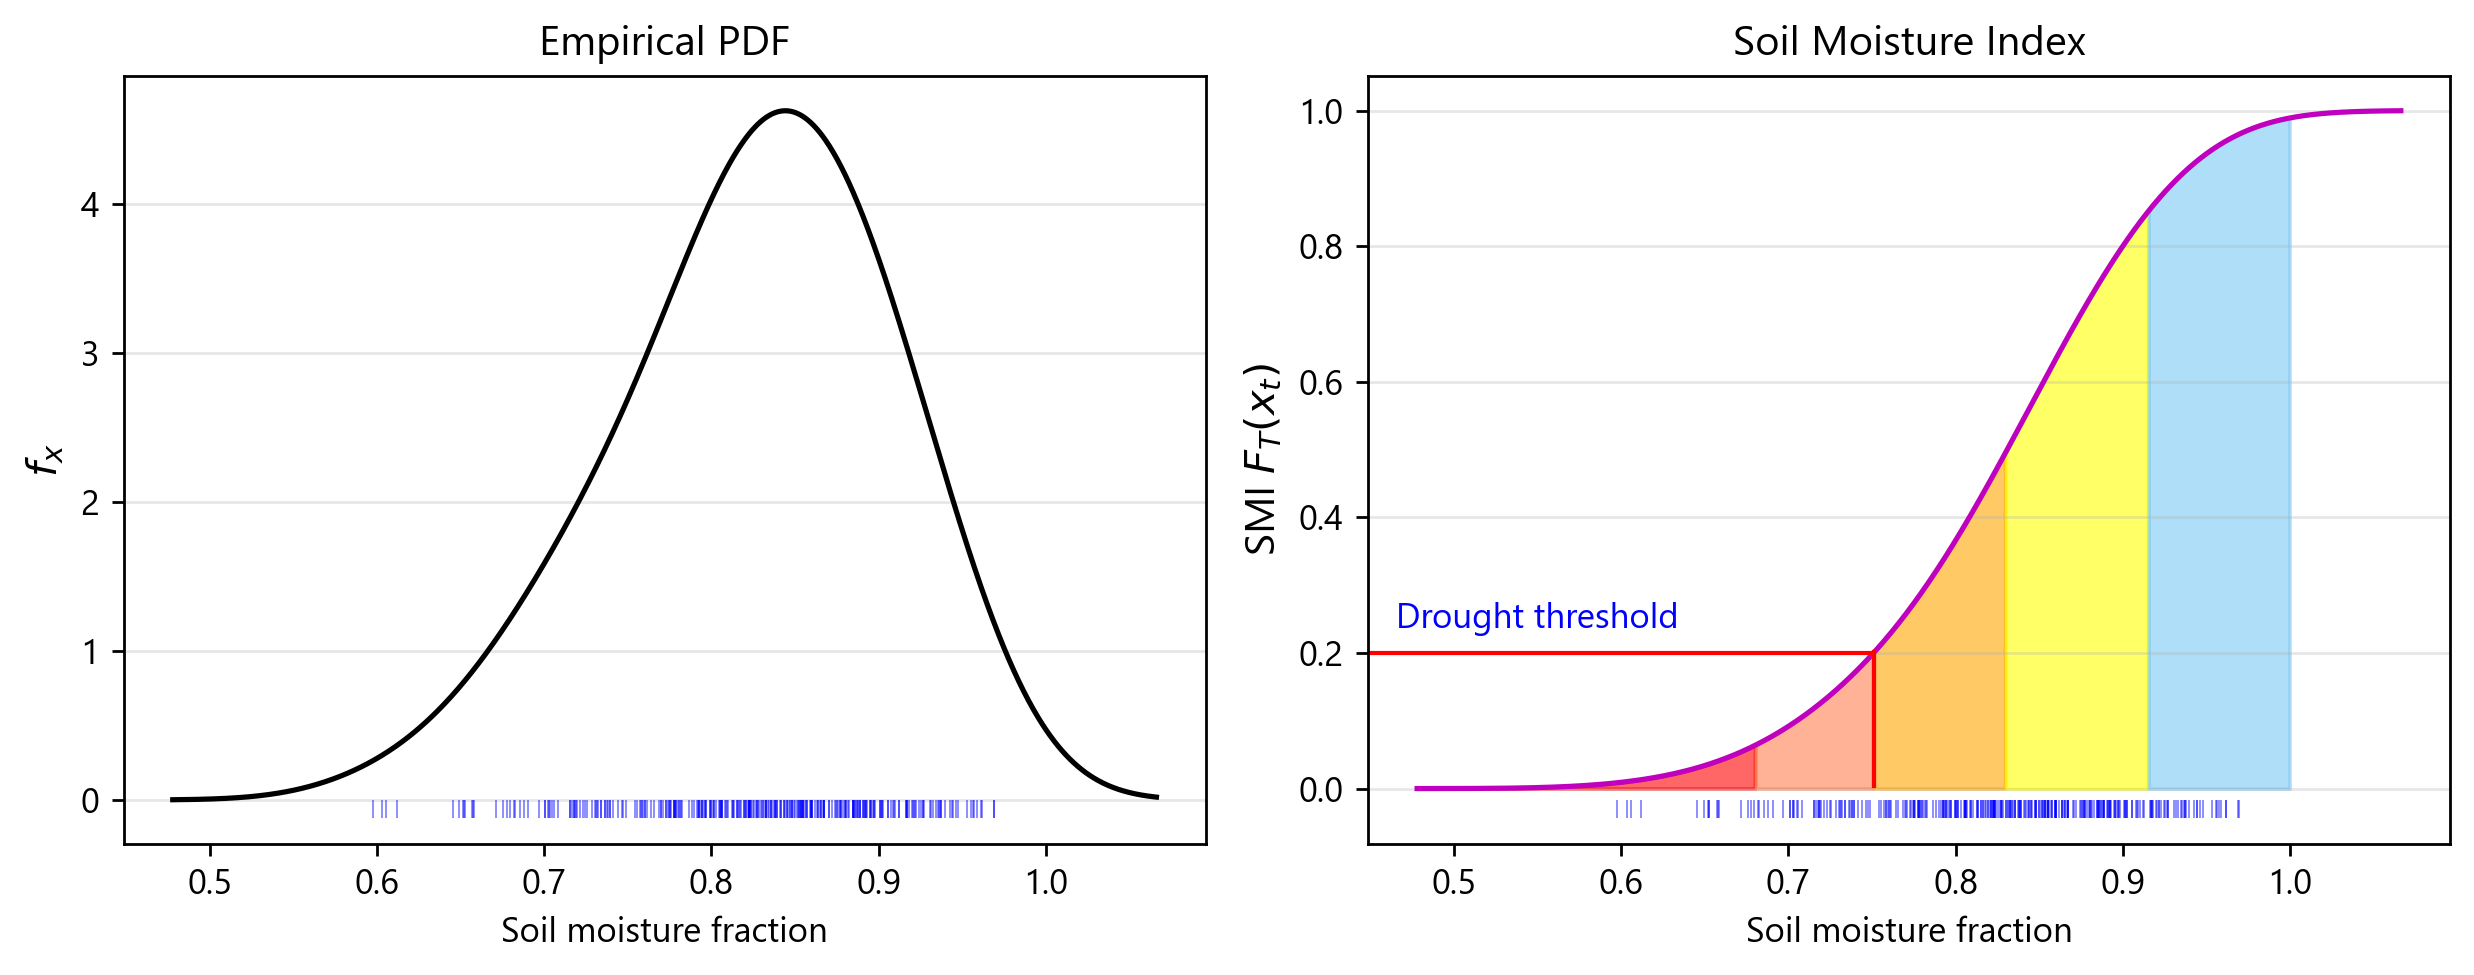

In [175]:

# Define threshold boundaries and colors for shading
# You can customize these thresholds and colors as needed
thresholds = [0.478, 0.68, sm_02, 0.83, 0.915,1.0]
colors = ['r', 'coral','orange', '#FFFF00', '#7BC8F6']

plt.figure(figsize=(10, 4), dpi=250)

##################################
# Subplot 1: PDF
##################################
plt.subplot(1, 2, 1)
plt.plot(x, prob_density, c='k')
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.06), '|b',
         markeredgewidth=0.5, markersize=5, alpha=0.5)

plt.xlabel('Soil moisture fraction', fontsize=10)
plt.ylabel('$f_{x}$', fontsize=12)
plt.title('Empirical PDF', fontsize=12)
plt.grid(axis='y', alpha=0.3)

##################################
# Subplot 2: CDF + Shading
##################################
plt.subplot(1, 2, 2)

# Plot the CDF
plt.plot(x, cdf, label='CDF', color='m', lw=1.5)

# Add a vertical line at the 20% threshold at x=0.68 and y 0 to 1
plt.axvline(x=sm_02, ymin=0.075, ymax=0.25, color='red', lw=1.2)
plt.axhline(y=0.2, xmin=0.0, xmax=0.465, color='red', lw=1.2)


#Add small ticks for the soil_moisture samples
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.03), '|b',
         markeredgewidth=0.5, markersize=5, alpha=0.5)


# Add shading between thresholds
for i in range(len(thresholds) - 1):
    plt.fill_between(
        x,             # array of x-values
        0,             # lower boundary of fill
        cdf,           # upper boundary of fill
        where=((x >= thresholds[i]) & (x <= thresholds[i+1])),
        color=colors[i],
        alpha=0.6,
    )

plt.grid(axis='y', alpha=0.3)
plt.text(0.55, 0.25, 'Drought threshold', fontsize=10, color='b', rotation=0, ha='center', va='center')
plt.xlabel('Soil moisture fraction', fontsize=10)
plt.ylabel('SMI $F_{T} (x_{t})$', fontsize=12)
plt.title('Soil Moisture Index', fontsize=12)
plt.tight_layout()
plt.show()


### Spatial cumulative distribution functions

In [ ]:
#select the variable of interest
variable = 'SM_Lall'

#select the data for the variable of interest
data_mon = mhm_fluxes_mon[[variable]]

#Period of interest. In this case, the vegetation active season
active_season = [4,5,6,7,8,9,10]

#extract values for summer months
data_vas_mons = data_mon.sel(time=data_mon.time.dt.month.isin(active_season))

#average soil moisture for active vegetation months for each year
data_vas_avg = data_vas_mons.groupby('time.year').mean()


In [ ]:

cdf_length = 100  # Number of points for the CDF, adjust according to the length of the time series
# Initialize a 3D array for storing the CDFs
# Dimensions: [lat, lon, cdf_length]
for month in active_season:
    # Extract values for the current month
    data_mon = data_vas_mons.sel(time=data_vas_mons.time.dt.month==month)

    cdf_array = np.full((len(data_mon.lat), len(data_mon.lon), cdf_length), np.nan)
    # Initialize a 3D array for storing the unique soil moisture bins for each grid cell
    # Dimensions: [lat, lon, cdf_length]
    # These bins represent the range of soil moisture values over which the CDF is computed.
    sm_bins_map = np.full((len(data_mon.lat), len(data_mon.lon), cdf_length), np.nan)

    # Loop through the grid cells
    for i in range(len(data_mon.lon)):  # Longitude dimension
        for j in range(len(data_mon.lat)):  # Latitude dimension
            # Extract the time series for the current grid cell

            soil_moisture = data_mon[variable].sel(
                            lon=data_mon.lon[i], 
                            lat=data_mon.lat[j], 
                            method='nearest').values  # Directly extract as numpy array
            
            # Skip grid cells where the entire time series is NaN
            if np.isnan(soil_moisture).all():
                continue  # Move to the next grid cell

            # Remove NaN values from the time series
            soil_moisture = soil_moisture[~np.isnan(soil_moisture)]

            # Compute optimal bandwidth for KDE
            bandwidths = np.linspace(0.001, 0.1, 25)
            optimal_h = compute_optimal_h(soil_moisture, bandwidths)

            # Perform KDE
            kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
            kde.fit(soil_moisture[:, None])

            # Define the unique bins (x-axis values) for the current grid cell's CDF
            # Bins represent a range of soil moisture values specific to the grid cell
            # The range is set to 90% of the minimum to 110% of the maximum soil moisture
            sm_bins = np.linspace(
                soil_moisture.min() * 0.9,  # Slightly below the minimum soil moisture
                soil_moisture.max() * 1.1,  # Slightly above the maximum soil moisture
                cdf_length  # Number of bins (same as the number of CDF points)
            )
            
            # Store the bins for the current grid cell. This will be used later for computing percentiles
            sm_bins_map[j, i, :] = sm_bins  

            # Evaluate the PDF at the bin points
            # The PDF is computed using the fitted KDE model
            logprob = kde.score_samples(sm_bins[:, None])  # Log probabilities for the bins
            prob_density = np.exp(logprob)  # Convert log probabilities to regular probabilities (PDF)

            # Compute the CDF by integrating the PDF using the cumulative sum
            # The cumulative sum is scaled by the spacing between bins
            cdf = np.cumsum(prob_density) * (sm_bins[1] - sm_bins[0])  # Numerical integration
            cdf_array[j, i, :] = cdf  # Store the computed CDF for this grid cell

#### Monthly CDF computation

In [ ]:
# Define constants
variable = 'SM_Lall'
cdf_length = 100  # Number of points for the CDF

# Create lists to store data for Dataset creation
cdf_data = []
bin_data = []
month_data = []

# Loop through summer months
for month in active_season:
    # Extract values for the current month
    data_mon = data_vas_mons.sel(time=data_vas_mons.time.dt.month == month)

    # Initialize arrays to store CDFs and bins for the current month
    cdf_array = np.full((len(data_mon.lat), len(data_mon.lon), cdf_length), np.nan)
    sm_bins_map = np.full((len(data_mon.lat), len(data_mon.lon), cdf_length), np.nan)

    # Loop through the grid cells
    for i in range(len(data_mon.lon)):  # Longitude dimension
        for j in range(len(data_mon.lat)):  # Latitude dimension
            # Extract the time series for the current grid cell
            soil_moisture = data_mon[variable].sel(
                lon=data_mon.lon[i],
                lat=data_mon.lat[j],
                method='nearest'
            ).values  # Convert to numpy array

            # Skip grid cells where the entire time series is NaN
            if np.isnan(soil_moisture).all():
                continue  # Move to the next grid cell

            # Remove NaN values from the time series
            soil_moisture = soil_moisture[~np.isnan(soil_moisture)]

            # Compute optimal bandwidth for KDE
            bandwidths = np.linspace(0.001, 0.1, 25)
            optimal_h = compute_optimal_h(soil_moisture, bandwidths)

            # Perform KDE
            kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
            kde.fit(soil_moisture[:, None])

            # Define unique bins for the CDF
            sm_bins = np.linspace(
                soil_moisture.min() * 0.9,  # Slightly below minimum
                soil_moisture.max() * 1.1,  # Slightly above maximum
                cdf_length
            )
            sm_bins_map[j, i, :] = sm_bins  # Store bins for this grid cell

            # Evaluate PDF and compute CDF
            logprob = kde.score_samples(sm_bins[:, None])  # Log probabilities
            prob_density = np.exp(logprob)  # Convert log probabilities to PDF
            cdf = np.cumsum(prob_density) * (sm_bins[1] - sm_bins[0])  # Compute CDF
            cdf_array[j, i, :] = cdf  # Store CDF

    # Append results to lists for Dataset creation
    cdf_data.append(cdf_array)
    bin_data.append(sm_bins_map)
    month_data.append(month)

# Convert lists to xarray.DataArray
cdf_da = xr.DataArray(
    np.stack(cdf_data, axis=0),  # Stack along the month axis
    dims=['month', 'lat', 'lon', 'cdf_bin'],
    coords={
        'month': month_data,
        'lat': data_mon.lat,
        'lon': data_mon.lon,
        'cdf_bin': np.arange(cdf_length)
    },
    name='CDF'
)

bins_da = xr.DataArray(
    np.stack(bin_data, axis=0),  # Stack along the month axis
    dims=['month', 'lat', 'lon', 'cdf_bin'],
    coords={
        'month': month_data,
        'lat': data_mon.lat,
        'lon': data_mon.lon,
        'cdf_bin': np.arange(cdf_length)
    },
    name='Bins'
)

# Combine into a Dataset
cdf_dataset = xr.Dataset({'CDF': cdf_da, 'Bins': bins_da})

# Save or visualize the dataset
print(cdf_dataset)

### Spatial Soil Moisture Index

In [ ]:
#dummy time dimension from 0 to len of cdf
time = np.arange(cdf_length)

cdf_data = xr.DataArray(
    data=cdf_array,
    coords={
            "lat": data_vas_mons.lat.values,
            "lon": data_vas_mons.lon.values,
            "time": time
            },
    dims=["lat", "lon", "time"]
)

#to dataset
cdf_ds = cdf_data.to_dataset(name='cdf')

#### Extract Grid Cell SM Percentiles

In [ ]:
drought_threshold = 0.2  # Percentile threshold for drought classification
time_steps = data_vas_mons.time.shape[0]  # Number of time steps in the dataset

# Initialize a 3D array for storing the adjusted drought classification map
# Shape: [time_steps, latitude, longitude]
# Values: Actual percentile (if <= 0.5), NaN (if > 0.5), NaN (if no data)
drought_map = np.full((time_steps, len(data_vas_mons.lat), len(data_vas_mons.lon)), np.nan)

# Initialize a 3D array for storing percentile ranks of soil moisture for each time step and grid cell
# Shape: [time_steps, latitude, longitude]
percentile_map = np.full((time_steps, len(data_vas_mons.lat), len(data_vas_mons.lon)), np.nan)

# Loop through each grid cell
for i in range(len(data_vas_mons.lon)):  # Longitude dimension
    for j in range(len(data_vas_mons.lat)):  # Latitude dimension
        # Extract the historical CDF and bins for the current grid cell
        cdf = cdf_array[j, i, :]  # Extract the precomputed CDF for the grid cell
        cdf_x = sm_bins_map[j, i, :]  # Extract the corresponding soil moisture bins
        
        # Skip cells with no valid CDF data (all NaN values)
        if np.isnan(cdf).all():
            continue  # Move to the next grid cell

        # Loop through each time step to classify drought conditions
        for t in range(time_steps):
            # Extract the soil moisture value at the current time step for the grid cell
            current_sm = data_vas_mons[variable].isel(lon=i, lat=j, year=t).values

            # Skip if the soil moisture value is NaN
            if np.isnan(current_sm):
                continue

            # Find the percentile rank of the current soil moisture in the CDF
            # Linear interpolation is used to find the percentile rank
            percentile_rank = np.interp(current_sm, cdf_x, cdf)  # Interpolates between cdf_x and cdf values
            percentile_map[t, j, i] = percentile_rank  # Store the percentile rank

            # Modify the drought map logic
            # If the percentile rank is above 0.5, set it as NaN
            # Otherwise, save the actual percentile rank
            if percentile_rank > 0.5:
                drought_map[t, j, i] = np.nan  # Mark as NaN
            else:
                drought_map[t, j, i] = percentile_rank  # Save the actual percentile rank


In [ ]:
drought_data = xr.DataArray(
    data=drought_map,
    coords={"time":data_vas_mons.time.values, "lat": data_vas_mons.lat.values, "lon": data_vas_mons.lon.values},
    dims=["time","lat", "lon"]
)

percentile_data = xr.DataArray(
    data=percentile_map,
    coords={"time":data_vas_mons.year.values, "lat": data_vas_mons.lat.values, "lon": data_vas_mons.lon.values},
    dims=["time","lat", "lon"]
)

#save as xr.Dataset
percentile_data = percentile_data.to_dataset(name='percentile')
drought_data = drought_data.to_dataset(name='drought')

In [ ]:
#Export the data
drought_data.to_netcdf(r"W:\VUB\_main_research\mHM\mhm_outputs\drought_data_corrected.nc")
percentile_data.to_netcdf(r"W:\VUB\_main_research\mHM\mhm_outputs\SM_Lall_percentile_data_corrected.nc")
# cdf_data.to_netcdf(r"W:\VUB\_main_research\mHM\mhm_outputs\SM_Lall_cdf_data_corrected.nc")

In [ ]:
drought_percentile = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\SM_Lall_percentile_data_corrected.nc")

In [ ]:
drought_percentile['drought'].isel(time=47).plot(robust=True)

In [ ]:
fig, ax = plt.subplots(10, 7,subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10), dpi=180)
# Flatten the 2D array of axes
axes = ax.flatten()
plt.subplots_adjust(hspace=-0.5, wspace=0.3)
# Loop through each time slice and its corresponding subplot
for i, time in enumerate(drought_percentile.time.values):
    if i < len(axes):  # Ensure we do not exceed the number of subplots
        im = drought_percentile['percentile'].sel(time=time).plot(
            ax=axes[i], cmap='RdBu',
            robust=True,
            vmin=0.0,
            vmax=1.0,
            add_colorbar=False
        )
        axes[i].set_title(str(time), fontsize=4, x=0.4, y=0.85)  # Add a small title to each plot
        be_shp.boundary.plot(ax=axes[i], edgecolor='black', linewidth=0.1)
        # Remove the frame
        axes[i].set_frame_on(False)
    else:
        break
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# Add a shared colorbar
cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SMI Percentile')
cbar_ax.tick_params(labelsize=8)
plt.show()

In [ ]:
#extract sm values for the selected grid cell
sample_ts = data_summer_avg['SM_L02'].mean(dim =['lat', 'lon'])
ts_df = sample_ts.to_dataframe()
soil_moisture = ts_df['SM_L02'].values

plt.plot(cdf_x, cdf_data.mean(dim=['lat','lon']))
#plot soil moisture values
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)

#plot average soil moisture for 1976
plt.axvline(data_summer_avg['SM_L02'][6].mean(dim =['lat', 'lon']), color='red', lw=0.5)
plt.axvline(data_summer_avg['SM_L02'][50].mean(dim =['lat', 'lon']), color='orange', lw=0.5)

plt.xlabel("SMC")
plt.ylabel("CDF")
plt.show()

In [ ]:
#subset where data < 0.2
drought_data_subset = drought_percentile

### Stacked area charts

In [ ]:
variable = 'percentile'

# Drop NaN values before calculating percentiles
valid_values = drought_data_subset[variable].values[~np.isnan(drought_data_subset[variable].values)]

# Define the percentiles
percentiles = [2,5,10,20,30,50,70,95]
percentile_labels = ['Exceptionally dry', 'Extreme drought', 'Severe drought',
                     'Moderate drought', 'Abnormally dry','Normal conditions',
                     'Wetter than normal', 'Very wet', 'Extremely wet']

# Calculate the percentile thresholds for the valid dataset
thresholds = np.percentile(valid_values, percentiles)

# Include bounds for categories
bounds = [-np.inf] + list(thresholds) + [np.inf]


# Group by year and classify data
results = []
for year, data in drought_data_subset.groupby('time'):
    # Classify data into percentile bins
    binned = xr.apply_ufunc(
        np.digitize,
        data[variable],
        input_core_dims=[[]],
        kwargs={'bins': bounds},
    )
    
    # Count the number of values in each bin
    counts = [(binned == i).sum().item() for i in range(1, len(bounds))]
    results.append([year] + counts)

# Convert results into a DataFrame
df = pd.DataFrame(results, columns=['Year'] + percentile_labels)
df=df.set_index('Year')

#calculate the percentage of each category
df_perc = df.div(df.sum(axis=1), axis=0) * 100


In [ ]:
# Plot the stacked area chart
fig, ax = plt.subplots(figsize=(15, 4.5),dpi=150)
ax.stackplot(df_perc.index, df_perc.iloc[:,[1,2,3,4,5,6,7]].T, labels=percentile_labels[0:7], colors = ['darkred','red','darkorange','gold','yellow','paleturquoise','deepskyblue'])
ax.set_ylabel("% Area")
ax.legend(loc='upper center', bbox_to_anchor=(0.7, 1.15), ncols =4)
plt.show()

In [ ]:
#drought areas as cirles per year
# Define the size of the circles
sizes = df.iloc[:, 7]

# Plot the drought areas
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
sc = ax.scatter(df.Year, np.full_like(df.Year, 50.75), s=sizes, c='red', alpha=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Latitude')
plt.colorbar(sc, label='Drought area')
plt.show()

### Drought Areas

In [ ]:
drought = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\drought_SM_Lall_data.nc")

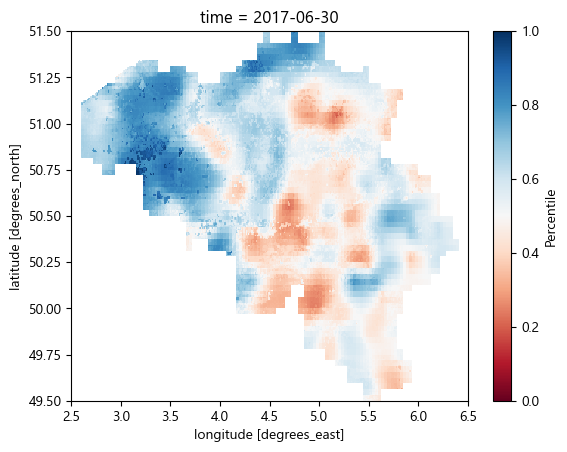

In [75]:
#plot the drought data
vmin = 0
vmax = 1
drought['Percentile'].sel(time='2017-06-30').plot(vmin=vmin, vmax=vmax, cmap='RdBu')